In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from feature_engine.encoding import RareLabelEncoder
from feature_engine.encoding import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV

from feature_engine.encoding import OrdinalEncoder

from math import sqrt

In [2]:
spain = pd.read_csv('spanish_wines_cleaned.csv')
spain

,Wine,Winery,Region,Sub Region,Year,Type,Grape,Alcohol,Review Score,Price
0,Pradorey Gran Reserva,Real Sitio de la Ventosilla (Pradorey),Castilla y León,Ribera del Duero,2009.0,Red,"Tempranillo (95%), Cabernet Sauvignon (3%), Me...",15.0,16.0,40.00
1,Guitián Fermentado en Barrica,Bodegas A Tapada,Galicia,Valdeorras,1998.0,White,Godello (100%),12.0,16.5,13.82
2,Raimat Cabernet Sauvignon El Molí,Raimat,Cataluña,Costers del Segre,1994.0,Red,Cabernet Sauvignon (100%),13.5,16.0,15.00
3,Valsacro Tinto Crianza,Bodegas Valsacro,La Rioja (España),Rioja,1997.0,Red,"Tempranillo (50%), Otras (40%), Mazuelo (10%)",13.0,14.5,18.00
4,Ruiz Villanueva Maceración Carbónica,Bodega Ecológica Bruno Ruiz,Castilla La Mancha,Otros Castilla La Mancha,1999.0,Red,Tempranillo (100%),12.0,12.5,4.50
...,...,...,...,...,...,...,...,...,...,...
16814,El Cuentista,Real Sitio de la Ventosilla (Pradorey),Unknown,Otros España,2018.0,Red,Tempranillo,13.5,14.0,17.00
16815,Pradorey Rosado,Real Sitio de la Ventosilla (Pradorey),Castilla y León,Ribera del Duero,2018.0,Red,"Tempranillo, Merlot",14.5,14.0,9.00
16816,Pradorey Origen,Real Sitio de la Ventosilla (Pradorey),Castilla y León,Ribera del Duero,2018.0,Red,"Tempranillo, Cabernet Sauvignon",14.0,14.0,7.50
16817,Lia,Real Sitio de la Ventosilla (Pradorey),Castilla y León,Ribera del Duero,2019.0,Rose,Tempranillo,13.5,13.5,6.50


### Pre-Processing

In [3]:
## Exploring cardinality
print('Number of categories in the variable Winery: {}'.format(
    len(spain.Winery.unique())))

print('Number of categories in the variable Wine: {}'.format(
    len(spain.Wine.unique())))

print('Number of categories in the variable Region: {}'.format(
    len(spain.Region.unique())))

print('Number of categories in the variable Sub Region: {}'.format(
    len(spain['Sub Region'].unique())))

print('Number of categories in the variable Type: {}'.format(
    len(spain.Type.unique())))

print('Number of categories in the variable Grape: {}'.format(
    len(spain.Grape.unique())))

Number of categories in the variable Winery: 1770
Number of categories in the variable Wine: 9742
Number of categories in the variable Region: 17
Number of categories in the variable Sub Region: 104
Number of categories in the variable Type: 6
Number of categories in the variable Grape: 3181


In [4]:
## Dealing with Grapes: There are wines that come 100% from one grape and others are mixed. My approach is to extract the main grape and label the wines as pure or mixed

## extract the main grape variety
spain['Main Variety'] = spain['Grape'].str.extract('(\w+)', expand=False)

## count the number of elements
spain['Variety Count'] = spain['Grape'].str.count(',') + 1

## mark as 'Pure' if there is only one variety
spain.loc[spain['Variety Count'] == 1, 'Variety Class'] = 'Pure'

## mark as 'Mixed' if there are multiple grape varieties
spain.loc[spain['Variety Count'] > 1, 'Variety Class'] = 'Mixed'

In [5]:
## Visualising results:
spain[['Wine','Grape','Main Variety','Variety Class']]

,Wine,Grape,Main Variety,Variety Class
0,Pradorey Gran Reserva,"Tempranillo (95%), Cabernet Sauvignon (3%), Me...",Tempranillo,Mixed
1,Guitián Fermentado en Barrica,Godello (100%),Godello,Pure
2,Raimat Cabernet Sauvignon El Molí,Cabernet Sauvignon (100%),Cabernet,Pure
3,Valsacro Tinto Crianza,"Tempranillo (50%), Otras (40%), Mazuelo (10%)",Tempranillo,Mixed
4,Ruiz Villanueva Maceración Carbónica,Tempranillo (100%),Tempranillo,Pure
...,...,...,...,...
16814,El Cuentista,Tempranillo,Tempranillo,Pure
16815,Pradorey Rosado,"Tempranillo, Merlot",Tempranillo,Mixed
16816,Pradorey Origen,"Tempranillo, Cabernet Sauvignon",Tempranillo,Mixed
16817,Lia,Tempranillo,Tempranillo,Pure


In [6]:
## Perfect! From 3181 categories to 157 and keeping information about pureness
print('Number of categories in the variable Grape: {}'.format(
    len(spain.Grape.unique())))
print('Number of categories in the variable Main Variety: {}'.format(
    len(spain['Main Variety'].unique())))

Number of categories in the variable Grape: 3181
Number of categories in the variable Main Variety: 157


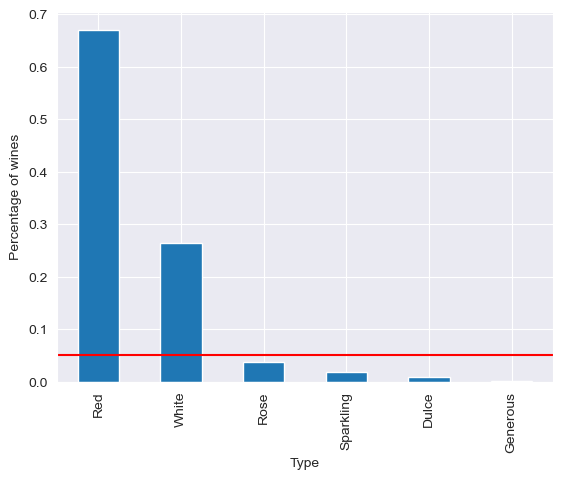

In [7]:
## I might consider using Rare Encoding for Types of wine below 5%
total_wines = len(spain)

temp_df = pd.Series(spain['Type'].value_counts() / total_wines)

fig = temp_df.sort_values(ascending=False).plot.bar()
fig.set_xlabel('Type')

fig.axhline(y=0.05, color='red')
fig.set_ylabel('Percentage of wines')
plt.show()

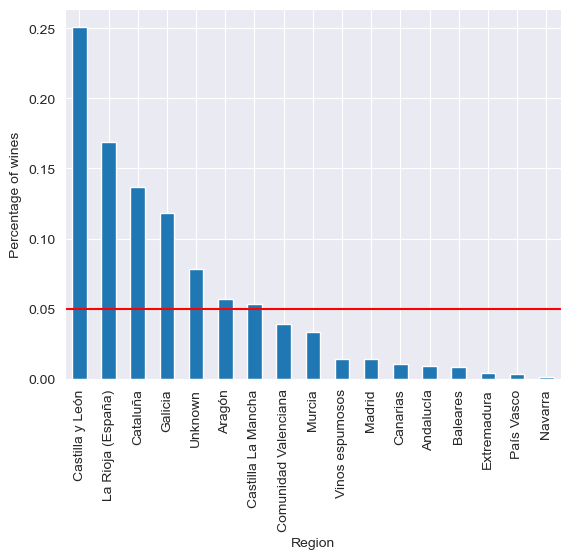

In [8]:
## I might consider using Rare Encoding for Regions of wine below 5%
total_wines = len(spain)

temp_df = pd.Series(spain['Region'].value_counts() / total_wines)

fig = temp_df.sort_values(ascending=False).plot.bar()
fig.set_xlabel('Region')

fig.axhline(y=0.05, color='red')
fig.set_ylabel('Percentage of wines')
plt.show()

In [9]:
## I will use OHE for Type, Region and Variety Class.
## Label Encoding for Winery, Sub Region and Main Variety as these are important features that affect price.
## I won't use Wine in my modelling as there are 9742 unique names.

In [53]:
spain.to_csv('spanish_wines_processed.csv', index=False)

## Train/Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    spain[['Winery','Region','Sub Region','Year','Type','Alcohol','Review Score','Main Variety','Variety Class']],
    spain['Price'],
    test_size=0.2,
    random_state=0,
)

X_train.shape, X_test.shape

((13455, 9), (3364, 9))

In [11]:
X_train.head(5)

,Winery,Region,Sub Region,Year,Type,Alcohol,Review Score,Main Variety,Variety Class
1437,Alejandro Fernández Tinto Pesquera,Castilla y León,Ribera del Duero,1998.0,Red,13.0,15.5,Tinto,Pure
8421,Bodegas Hacienda del Carche,Murcia,Jumilla,2009.0,Red,14.5,14.0,Monastrell,Mixed
6585,Eguren Ugarte,La Rioja (España),Rioja,2005.0,Red,13.5,12.0,Tempranillo,Mixed
1988,Artadi,La Rioja (España),Rioja,2000.0,Red,13.5,18.0,Tempranillo,Pure
15528,Cía. de Vinos del Atlántico,Galicia,Rías Baixas,2016.0,White,13.0,16.5,Albariño,Pure


In [12]:
X_test.head(5)

,Winery,Region,Sub Region,Year,Type,Alcohol,Review Score,Main Variety,Variety Class
6391,Buil & Giné,Cataluña,Priorat,2007.0,Red,14.0,14.0,Garnacha,Mixed
14930,Adega Ponte da Boga,Galicia,Ribeira Sacra,2016.0,White,13.0,15.0,Albariño,Pure
9281,Viña Albares,Castilla y León,Bierzo,2010.0,Red,13.0,12.5,Mencía,Pure
2795,Bodegas y Viñedos Viña Solorca,Castilla y León,Ribera del Duero,1999.0,Red,13.5,12.5,Tinto,Pure
14712,Bodegas y Viñedos Ortega Ezquerro,La Rioja (España),Rioja,2014.0,Red,14.0,16.0,Tempranillo,Mixed


## Feature Engineering

### Rare Label Encoding

In [13]:
rare_encoder = RareLabelEncoder(tol=0.05, n_categories=4, variables=['Type','Region'])
X_train_rare = rare_encoder.fit_transform(X_train)
X_test_rare = rare_encoder.transform(X_test)

In [14]:
X_test_rare.head(5)

,Winery,Region,Sub Region,Year,Type,Alcohol,Review Score,Main Variety,Variety Class
6391,Buil & Giné,Cataluña,Priorat,2007.0,Red,14.0,14.0,Garnacha,Mixed
14930,Adega Ponte da Boga,Galicia,Ribeira Sacra,2016.0,White,13.0,15.0,Albariño,Pure
9281,Viña Albares,Castilla y León,Bierzo,2010.0,Red,13.0,12.5,Mencía,Pure
2795,Bodegas y Viñedos Viña Solorca,Castilla y León,Ribera del Duero,1999.0,Red,13.5,12.5,Tinto,Pure
14712,Bodegas y Viñedos Ortega Ezquerro,La Rioja (España),Rioja,2014.0,Red,14.0,16.0,Tempranillo,Mixed


### Ordered Ordinal Encoding

In [15]:
vars_to_use = ['Winery','Sub Region','Main Variety']
enc = OrdinalEncoder(encoding_method='ordered',variables=vars_to_use,unseen='encode')
X_train_ordered = enc.fit_transform(X_train_rare,y_train)
X_test_ordered = enc.transform(X_test_rare)

In [16]:
X_test_ordered.head(5)

,Winery,Region,Sub Region,Year,Type,Alcohol,Review Score,Main Variety,Variety Class
6391,1047,Cataluña,94,2007.0,Red,14.0,14.0,89,Mixed
14930,1046,Galicia,71,2016.0,White,13.0,15.0,47,Pure
9281,438,Castilla y León,60,2010.0,Red,13.0,12.5,83,Pure
2795,806,Castilla y León,89,1999.0,Red,13.5,12.5,116,Pure
14712,891,La Rioja (España),82,2014.0,Red,14.0,16.0,104,Mixed


### One Hot Encoding

In [17]:
cols_to_use = ['Region','Type','Variety Class']
oh_encoder = OneHotEncoder(variables=cols_to_use, drop_last=True)
X_train_ohe = oh_encoder.fit_transform(X_train_ordered)
X_test_ohe = oh_encoder.transform(X_test_ordered)

In [18]:
X_test_ohe.head(5)

,Winery,Sub Region,Year,Alcohol,Review Score,Main Variety,Region_Castilla y León,Region_Rare,Region_La Rioja (España),Region_Galicia,Region_Cataluña,Region_Castilla La Mancha,Region_Unknown,Type_Red,Type_White,Variety Class_Pure
6391,1047,94,2007.0,14.0,14.0,89,0,0,0,0,1,0,0,1,0,0
14930,1046,71,2016.0,13.0,15.0,47,0,0,0,1,0,0,0,0,1,1
9281,438,60,2010.0,13.0,12.5,83,1,0,0,0,0,0,0,1,0,1
2795,806,89,1999.0,13.5,12.5,116,1,0,0,0,0,0,0,1,0,1
14712,891,82,2014.0,14.0,16.0,104,0,0,1,0,0,0,0,1,0,0


### Putting it all together

In [19]:
spain_pipe = Pipeline([

    ## Rare Label Encoding
    ('rare_encoder',
     RareLabelEncoder(tol=0.05, n_categories=4, variables=['Type','Region'])),

    ## Ordered Ordinal Encoding
    ('ordinal_encoder',
     OrdinalEncoder(encoding_method='ordered', variables=['Winery','Sub Region','Main Variety'], unseen='encode')),

    ## One Hot Encoding
    ('encoder_rare_label',
     OneHotEncoder(variables=['Region','Type','Variety Class'], drop_last=True)),

    ## Scaling
    ('minmax_scaler',
     MinMaxScaler()),
])

In [20]:
spain_pipe.fit(X_train,y_train)

Pipeline(steps=[('rare_encoder',
                 RareLabelEncoder(n_categories=4,
                                  variables=['Type', 'Region'])),
                ('ordinal_encoder',
                 OrdinalEncoder(unseen='encode',
                                variables=['Winery', 'Sub Region',
                                           'Main Variety'])),
                ('encoder_rare_label',
                 OneHotEncoder(drop_last=True,
                               variables=['Region', 'Type', 'Variety Class'])),
                ('minmax_scaler', MinMaxScaler())])

In [21]:
X_train_enc = spain_pipe.transform(X_train)
X_test_enc = spain_pipe.transform(X_test)

X_train_enc

array([[0.92583873, 0.8989899 , 0.27586207, ..., 1.        , 0.        ,
        1.        ],
       [0.28781636, 0.22222222, 0.65517241, ..., 1.        , 0.        ,
        0.        ],
       [0.57445556, 0.82828283, 0.51724138, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.39670394, 0.51515152, 0.55172414, ..., 1.        , 0.        ,
        0.        ],
       [0.6592113 , 0.60606061, 0.62068966, ..., 1.        , 0.        ,
        1.        ],
       [0.91112419, 0.82828283, 0.34482759, ..., 1.        , 0.        ,
        0.        ]])

## Modelling

In [22]:
# define the models
models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'ExtraTreeRegressor': ExtraTreeRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'HistGradientBoostingRegressor': HistGradientBoostingRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'BaggingRegressor': BaggingRegressor(),
    'LinearRegression': LinearRegression(),
    'MLPRegressor': MLPRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'LGBMRegressor': LGBMRegressor()
}

# fit the models and make predictions on the test set
results = []
for name, model in models.items():
    model.fit(X_train_enc, y_train)
    y_pred = model.predict(X_test_enc)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append((name, r2, adj_r2, rmse))

# print the results
results_df = pd.DataFrame(results, columns=['Model', 'R-squared', 'Adjusted R-squared', 'RMSE'])
print(results_df)

/Users/gleb/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


                            Model  R-squared  Adjusted R-squared       RMSE
0           DecisionTreeRegressor   0.154732            0.152464  13.378869
1              ExtraTreeRegressor   0.181476            0.179280  13.165512
2             ExtraTreesRegressor   0.519029            0.517739  10.092098
3       GradientBoostingRegressor   0.530261            0.529001   9.973565
4   HistGradientBoostingRegressor   0.558639            0.557455   9.667610
5           RandomForestRegressor   0.534436            0.533187   9.929143
6                BaggingRegressor   0.504076            0.502745  10.247781
7                LinearRegression   0.397163            0.395546  11.298529
8                    MLPRegressor   0.514780            0.513478  10.136581
9               AdaBoostRegressor   0.315443            0.313606  12.040011
10                  LGBMRegressor   0.554737            0.553542   9.710248


## HistGradientBoostingRegressor

In [55]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_iter': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 5, 10],
    'max_leaf_nodes': [None, 10, 50],
    'l2_regularization': [0, 0.1, 1]
}

In [56]:
hgb = HistGradientBoostingRegressor()
grid_search = GridSearchCV(hgb, param_grid=param_grid, cv=5, n_jobs=-1)

In [57]:
grid_search.fit(X_train_enc, y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(), n_jobs=-1,
             param_grid={'l2_regularization': [0, 0.1, 1],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7], 'max_iter': [100, 200, 500],
                         'max_leaf_nodes': [None, 10, 50],
                         'min_samples_leaf': [1, 5, 10]})

In [58]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'max_iter': 100, 'max_leaf_nodes': None, 'min_samples_leaf': 10}
0.5963102119217577


In [59]:
# Train HGB regressor using best hyperparameters
best_params = grid_search.best_params_
hgb_best = HistGradientBoostingRegressor(**best_params)
hgb_best.fit(X_train_enc, y_train)

HistGradientBoostingRegressor(l2_regularization=0.1, max_depth=7,
                              max_leaf_nodes=None, min_samples_leaf=10)

In [60]:
print(hgb_best.score(X_train_enc, y_train))
print(hgb_best.score(X_test_enc, y_test))

0.7370699987994545
0.5498136572334166


## LGBM Regressor

In [29]:
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100, 200],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

In [30]:
lgb_model = LGBMRegressor()

In [31]:
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_enc, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.1],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [10, 20, 30], 'reg_alpha': [0, 0.1, 0.5],
                         'reg_lambda': [0, 0.1, 0.5]})

In [32]:
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Hyperparameters:  {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 30, 'reg_alpha': 0.5, 'reg_lambda': 0}
Best Score:  0.6025396954569258


In [33]:
# Train LGBM regressor using best hyperparameters
best_params = grid_search.best_params_
lgb_best = LGBMRegressor(**best_params)
lgb_best.fit(X_train_enc, y_train)

LGBMRegressor(n_estimators=200, num_leaves=30, reg_alpha=0.5, reg_lambda=0)

In [34]:
print(lgb_best.score(X_train_enc, y_train))
print(lgb_best.score(X_test_enc, y_test))

0.7522756240718298
0.5632321685382102


<AxesSubplot:>

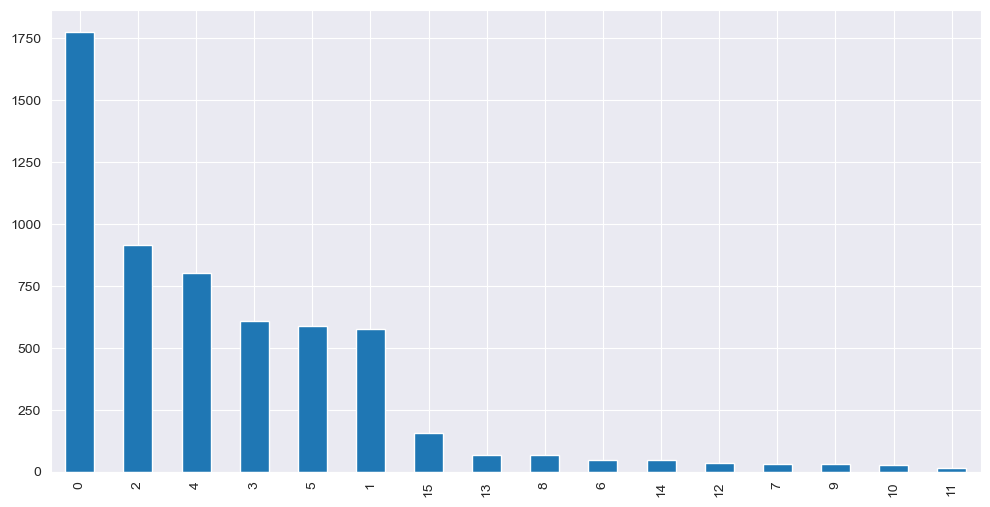

In [36]:
importance = pd.Series(lgb_best.feature_importances_)
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

## Random Forest Regressor

In [37]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [38]:
# Define the random forest regressor
rf = RandomForestRegressor()

In [39]:
# Perform the grid search
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_enc, y_train)

/Users/gleb/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [40]:
# Output the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Score:  0.6040222187367936


In [41]:
# Train a new random forest regressor using the best parameters
best_params = grid_search.best_params_
rf_best = RandomForestRegressor(**best_params)
rf_best.fit(X_train_enc, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=5)

In [42]:
print(rf_best.score(X_train_enc, y_train))
print(rf_best.score(X_test_enc, y_test))

0.8487195044124904
0.571399607627878


In [43]:
# Output the feature importances
feature_importances = rf_best.feature_importances_
print("Feature Importances: ", feature_importances)

Feature Importances:  [0.39849289 0.07733413 0.09227545 0.09983984 0.20434026 0.0559387
 0.00664262 0.00485441 0.00748534 0.002817   0.00630144 0.0023337
 0.00439875 0.01157546 0.00869875 0.01667126]


<AxesSubplot:>

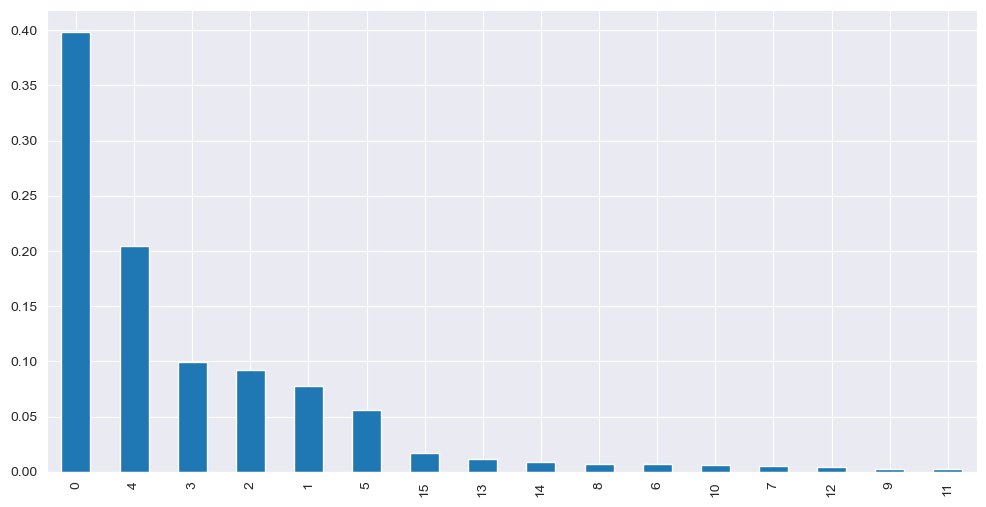

In [45]:
importance = pd.Series(rf_best.feature_importances_)
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

In [46]:
X_train_ohe.columns

Index(['Winery', 'Sub Region', 'Year', 'Alcohol', 'Review Score',
       'Main Variety', 'Region_Castilla y León', 'Region_Rare',
       'Region_La Rioja (España)', 'Region_Galicia', 'Region_Cataluña',
       'Region_Castilla La Mancha', 'Region_Unknown', 'Type_Red', 'Type_White',
       'Variety Class_Pure'],
      dtype='object')

In [47]:
X_train_preds = rf_best.predict(X_train_enc)
X_test_preds = rf_best.predict(X_test_enc)

In [50]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 31.920942362745677
train rmse: 5.64986215431365
train r2: 0.8487195044124904

test mse: 90.7604767012992
test rmse: 9.526829309969775
test r2: 0.571399607627878
